# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 :

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU

In [26]:
import argparse
import os
import time
from icecream import ic

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Partie 1 : Architecture VGG16

In [2]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
# !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
# !wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
# !wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

/tempory/PLDAC-Insectes/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/tempory/PLDAC-Insectes/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'sea slug, nudibranch'

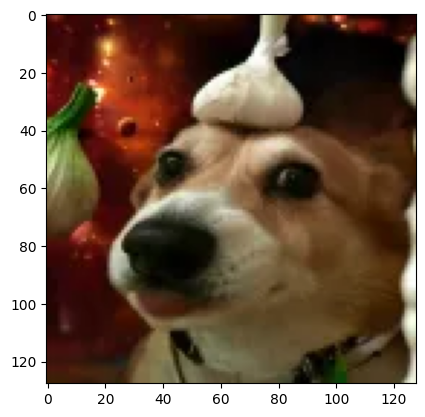

In [3]:
cat = Image.open('kadaver-vanilla.webp')
#dog = Image.open('dog.jpg')
plt.imshow(cat)
#plt.imshow(dog)
# Ajoutez vos images
# VOTRE CODE ICI pour le bonus:

vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval()
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes
img = Image.open("kadaver-vanilla.webp")
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))

img = np.expand_dims(img, 0)
x = torch.Tensor(img)
y = vgg16(x) # TODO calcul forward
idx = y.argmax()
imagenet_classes[idx.item()]

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [4]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
# !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

# !unzip 15ScenesData.zip

In [28]:
# ls 15SceneData/test/bedroom/

In [29]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
class VGG16relu17(nn.Module):
    def __init__(self, vgg16):
        super().__init__()
        vgg16 = torchvision.models.vgg16(pretrained=True)
        self.features = vgg16.features[:-1]
        self.avgpool = vgg16.avgpool
        self.classifier = vgg16.classifier[:-2]

    def forward(self, x):
        # ic(x.size())
        x = self.features(x)
        x = self.avgpool(x)
        # ic(x.size())
        x = x.view(x.size(0), -1)
        # ic(x.size())
        x = self.classifier(x)
        return x

PRINT_INTERVAL = 50
CUDA = True


def get_dataset(batch_size, path):

    def duplicateChannel(img):
        img = img.convert('RGB')
        # np_img = np.array(img, dtype=np.uint8)
        # np_img = np.dstack([np_img, np_img, np_img])
        # img = Image.fromarray(np_img, 'RGB')
        return img
    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda

    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Resize((224,224), interpolation=Image.NEAREST),
            transforms.Lambda(duplicateChannel),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))
    
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.Resize((224,224), interpolation=Image.NEAREST),
            transforms.Lambda(duplicateChannel),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

def extract_features(data, model):
    X = torch.tensor([])
    y = torch.tensor([])

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        X = torch.cat((X, model(input)))
        y = torch.cat((y, target))

    return torch.tensor(X), torch.tensor(y)


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16relu17(vgg16)

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm = LinearSVC(C=1.0).fit(X_train, y_train)
    accuracy = accuracy_score(y_test, svm.predict(X_test))
    print('Accuracy = %f' % accuracy)
main("15SceneData", 8)

Instanciation de VGG16


/tempory/PLDAC-Insectes/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/tempory/PLDAC-Insectes/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188


OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 7.78 GiB total capacity; 7.29 GiB already allocated; 82.00 MiB free; 7.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF